#PWC Agentic RAG

Ez a projekt egy  Agentic RAG chatbot megvalósítását mutatja be. A kód LangGraph segítségével olyan munkafolyamatot hoz létre, amely képes:

- releváns információkat keresni és értékelni egy tudásbázisból

- újrafogalmazni a lekérdezéseket, ha az információ elégtelen

- Az információkinyerés után, pedig válaszol. Ha nem talál releváns információt az vektoradatbázisban, akkor pedig saját tudása alapján válaszol.

Nem bonyolítottam túl, mivel ez egy próbafeladat, és így már eleget tesz az agentic működésnek.

Munkafolyamat:

- Kezdeti értékelés (ai_assistant): Meghatározza, hogy szükség van-e eszközökre, vagy közvetlen válaszadás lehetséges
- Dokumentum lekérdezés (retrieve_docs): Releváns dokumentumok lekérdezése vektoros kereséssel
- Relevancia értékelés (grade_documents): Értékeli, hogy a lekérdezett dokumentumok relevánsak-e
- Válaszgenerálás (generate_answer): Választ készít a lekérdezett dokumentumok alapján
- Lekérdezés átfogalmazása (rewrite_query): Újrafogalmazza a kérdéseket, ha a dokumentumok nem elegendőek


Ezek indokoltsága könnyen érthető egy RAG rendszernél. A lekérdezés átfogalmazása segíthet abban az esetben, ha nem tud helyesen irni a felhasználó, vagy rosszul teszi fel a kérdést, esetleg ha nincs doménbeli tudása.

Workflow:
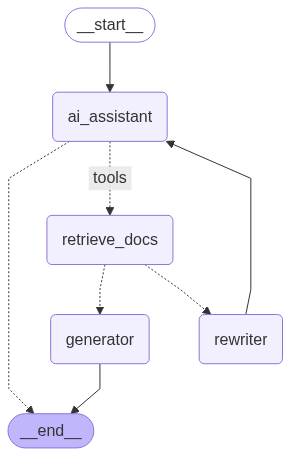

In [2]:
!pip install datasets==3.5.1 langgraph==0.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

In [3]:
!pip install bitsandbytes datasets sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
from __future__ import annotations
from typing_extensions import TypedDict, Annotated, NotRequired, Sequence, Literal
from typing import List, Dict, Any

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, CrossEncoder
from pydantic import BaseModel, Field
import faiss, numpy as np, torch, itertools, textwrap
from datasets import load_dataset
import uuid
import nltk
from nltk.corpus import stopwords


##Modellek betöltése

Qwen modellek nem teljesitenek olyan rosszul, és vannak kisebb modelljeik, ezért ezt használtam. A 7b modell kvantálva nem a legrosszabb, de nem is túl jó. Azért ez lett, mert ez fér bele a colab ingyenes gpu limitjébe. Az embedder és a reranker az véletlenszerűen lett kiválasztva

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B", trust_remote_code=True)
model     = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-7B",
    device_map="auto",
    load_in_4bit=True,
)
model.eval()
device   = "cuda" if torch.cuda.is_available() else "cpu"

embedder = SentenceTransformer("thenlper/gte-large", device=device)
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-12-v2", device=device)

## Adathalmaz

A wikipedia small-t válaszottam, mert nem túl nagy, de mégis jó arra, hogy információkinyerést megmutassa. Ezt felbotontottam chunkokra, amelyek max. 256 tokenek lehettek. Ezen felül, a paragrafafusok is figyelembe lettek véve, amit a \n mutat. Az elkészült chunkokat pedig feltölti a vektor adatbázisba, amihez a Faiss-t használtam, de lehetett volna chroma is. Csak 2000 dokumentumot töltöttem fel, hogy ne menjen el sok idő vele.

In [ ]:
raw_ds = load_dataset("not-lain/wikipedia-small-3000-embedded", split="train")

def chunk_text(text: str, max_tokens: int = 256) -> list[str]:
    paras = [p for p in text.split("\n") if len(p.split()) > 20]
    chunks, curr = [], []
    for p in paras:
        if sum(len(s.split()) for s in curr) + len(p.split()) > max_tokens:
            chunks.append(" ".join(curr))
            curr = [p]
        else:
            curr.append(p)
    if curr:
        chunks.append(" ".join(curr))
    return chunks

docs = []
for item in raw_ds:
    doc_title = item["title"]
    for chunk in chunk_text(item["text"], max_tokens=256):
        docs.append({
            "id":    item["id"],
            "title": doc_title,
            "text":  chunk
        })

print(f"Prepared {len(docs)} chunks from {len(raw_ds)} wiki pages.")
docs = docs[:2000]
def build_index(docs: list[dict]):
    embs = embedder.encode([d["text"] for d in docs], convert_to_numpy=True, show_progress_bar=True)
    faiss.normalize_L2(embs)
    idx = faiss.IndexFlatIP(embs.shape[1])
    idx.add(embs)
    return idx, embs

index, _ = build_index(docs)

A lekérdezési rendszer:
- Szemantikus keresés: Kezdeti jelöltek lekérdezése beágyazási hasonlóság alapján
- Cross-Encoder újrarangsorolás

In [4]:
class SimpleRetriever:
    def __init__(self, index, docs, embedder, k: int = 15):
        self.index, self.docs, self.embedder, self.k = index, docs, embedder, k

    def __call__(self, query: str):
        q = self.embedder.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(q)
        scores, ids = self.index.search(q, self.k)
        return [(self.docs[int(i)], float(s)) for i, s in zip(ids[0], scores[0])]

retriever = SimpleRetriever(index, docs, embedder, k=10)

def rerank(query: str, pairs, top_k: int = 3):
    if not pairs:
        return []
    texts = [p[0]["text"] for p in pairs]
    scores = reranker.predict(list(zip(itertools.repeat(query), texts)))
    ranked = sorted(zip(pairs, scores), key=lambda z: z[1], reverse=True)
    return [doc for (doc, _), _ in ranked[:top_k]]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/49.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3001 [00:00<?, ? examples/s]

Prepared 42600 chunks from 3001 wiki pages.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
class SearchTool:
    def __call__(self, query: str) -> str:
        print(f"Searching for: '{query}'")

        pairs = retriever(query)
        print(f"Top retrieval scores: {[score for _, score in pairs[:3]]}")

        reranked_docs = rerank(query, pairs, top_k=3)
        result = "\n\n".join([f"Document {i}:\n{doc['text']}" for i, doc in enumerate(reranked_docs, 1)])

        preview = result[:200] + "..." if len(result) > 200 else result
        print(f"Retrieved content preview: {preview}")

        return result

class AgentState(TypedDict, total=False):
    messages: Annotated[List[BaseMessage], add_messages]
    retrieved_docs: NotRequired[str]
    tools_used: NotRequired[bool]
    rewrite_count: NotRequired[int]
    original_question: NotRequired[str]

class Grade(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")


In [ ]:
def _convert_to_base_messages(messages):
    """
    Converts a list of mixed message formats (dicts, strings, or BaseMessages) into
    a standardized list of BaseMessage objects.
    """
    result = []
    for msg in messages:
        if isinstance(msg, dict):
            if msg["role"] == "user":
                result.append(HumanMessage(content=msg["content"]))
            elif msg["role"] == "assistant":
                result.append(AIMessage(content=msg["content"]))
        elif isinstance(msg, str):
            result.append(HumanMessage(content=msg))
        else:
            result.append(msg)
    return result

memory = MemorySaver()

Az ai_assistant eldönti, hogy egyből válaszoljon, vagy használjon valami toolt.

In [ ]:
def ai_assistant(state: AgentState):
    """
    Initial node that decides if tools are needed or direct answer is possible
    """
    print("---CALL AGENT---")
    messages = state.get('messages', [])

    messages = _convert_to_base_messages(messages)

    rewrite_count = state.get('rewrite_count', 0)

    original_question = state.get('original_question', '')
    if not original_question and messages:
        original_question = messages[0].content

    if len(messages) > 1 and not state.get('tools_used', False):
        last_message = messages[-1]
        question = last_message.content

        prompt = f"""You are an assistant for question-answering tasks.
                    Answer the following question with detailed information.

                    Question: {question}

                    DO NOT return just a number or short phrase.
                    Answer: """

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.inference_mode():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=200,
                min_new_tokens=50,
                do_sample=True,
                temperature=0.7,
                eos_token_id=tokenizer.eos_token_id,
                no_repeat_ngram_size=3
        )
        response = tokenizer.decode(output_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()

        return {"messages": [AIMessage(content=response)]}
    else:
        question = messages[0].content
        print(f"Processing question: '{question}'")

        search_tool = SearchTool()
        docs = search_tool(question)

        return {
            "retrieved_docs": docs,
            "tools_used": True,
            "messages": messages,
            "rewrite_count": rewrite_count,
            "original_question": original_question
        }

In [ ]:
def tools_condition(state: AgentState) -> str:
    """
    Determine whether to use tools or end the conversation
    """
    if state.get("tools_used", False):
        return "tools"
    return END

def retrieve_docs(state: AgentState):
    """
    Vector retrieval node
    """
    print("---RETRIEVE DOCUMENTS---")
    messages = state.get('messages', [])
    messages = _convert_to_base_messages(messages)

    retrieved_docs = state.get("retrieved_docs", "")

    return {
        "messages": messages + [AIMessage(content=retrieved_docs)],
        "rewrite_count": state.get('rewrite_count', 0),
        "original_question": state.get('original_question', '')
    }

A grade_documents függvénnyel osztályozzuk, hogy relevánsak-e a kinyert dokumentumok

In [ ]:
def grade_documents(state: AgentState) -> Literal["generator", "rewriter"]:
    """
    Grade documents for relevance
    """
    print("---GRADE DOCUMENTS---")
    messages = state.get('messages', [])
    messages = _convert_to_base_messages(messages)

    original_question = state.get('original_question', '')
    if not original_question and messages:
        original_question = messages[0].content

    question = messages[0].content
    docs = messages[-1].content

    rewrite_count = state.get('rewrite_count', 0)

    if rewrite_count >= 2:
        print(f"---DECISION: FORCED GENERATOR AFTER {rewrite_count} REWRITES---")
        return "generator"

    question_lower = question.lower()
    nltk.download('stopwords')
    stopwords_nltk = stopwords.words('english'))

    keywords = [word for word in question_lower.split() if len(word) > 2 and word.lower() not in stopwords_nltk]

    words = question_lower.split()
    if len(words) > 1:
        for i in range(len(words) - 1):
            if len(words[i]) >= 3 and len(words[i+1]) >= 3:
                phrase = f"{words[i]} {words[i+1]}"
                if phrase not in keywords and not any(word in stopwords_nltk for word in phrase.split()):
                    keywords.append(phrase)

    print(f"Question keywords: {keywords}")

    docs_lower = docs.lower()

    exact_matches = 0
    partial_matches = 0

    for keyword in keywords:
        if " " in keyword:
            if keyword in docs_lower:
                exact_matches += 1
                exact_matches += 0.5
        elif keyword in docs_lower:
            exact_matches += 1
        elif len(keyword) > 5:
            min_chars = int(len(keyword) * 0.7)
            for word in docs_lower.split():
                if len(word) >= min_chars and (keyword[:min_chars] in word or keyword[-min_chars:] in word):
                    partial_matches += 1
                    break

    total_matches = exact_matches + (partial_matches * 0.5)
    match_ratio = total_matches / len(keywords) if keywords else 0

    print(f"Keyword matches: {exact_matches} exact, {partial_matches} partial, ratio = {match_ratio:.2f}")

    if len(keywords) > 1 and match_ratio < 0.2:
        print("---DECISION: DOCS NOT RELEVANT (keyword check)---")
        return "rewriter"

    if match_ratio > 0.5 and exact_matches >= 2:
        print("---DECISION: DOCS RELEVANT (strong keyword match)---")
        return "generator"

    prompt = f"""You are evaluating if a set of documents contain information that could help answer a question.

                Question: {question}

                Documents: {docs}

                Consider the documents carefully. They don't need to fully answer the question,
                but they should contain information that would be helpful for constructing an answer.

                Even partial information that relates to the question's topic can be valuable.

                Answer with 'yes' if the documents contain information useful for addressing the question,
                or 'no' if they are completely unrelated to the question.
                """

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.inference_mode():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=32,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
        )
    response = tokenizer.decode(output_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip().lower()

    print(f"Grader response: {response}")

    is_relevant = False

    if "yes" in response and "no" not in response:
        is_relevant = True
    elif "no" in response and "yes" not in response:
        is_relevant = False
    else:
        is_relevant = match_ratio >= 0.3 or exact_matches >= 2

    if rewrite_count == 0 and match_ratio >= 0.25:
        is_relevant = True

    if rewrite_count == 1:
        is_relevant = match_ratio > 0.15 or exact_matches >= 1

    if is_relevant:
        print("---DECISION: DOCS RELEVANT---")
        return "generator"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter"

Ezzel generáljuk a választ

In [ ]:
def generate_answer(state: AgentState):
    """
    Generate final answer based on retrieved documents
    """
    print("---GENERATE ANSWER---")
    messages = state.get('messages', [])
    messages = _convert_to_base_messages(messages)

    question = messages[0].content
    docs = messages[-1].content

    print(f"Doksik:{docs}")
    print(question)
    prompt = f"""You are an assistant for question-answering tasks.
                Use the following pieces of retrieved context to answer the question.

                Question: {question}

                Context: {docs}

                If the context doesn't contain relevant information, simply answer based on your knowledge,
                but make it clear what parts are from your knowledge versus the provided context.
                Answer: """

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.inference_mode():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=200,
            min_new_tokens=50,
            do_sample=True,
            temperature=0.7,
            eos_token_id=tokenizer.eos_token_id,
            no_repeat_ngram_size=3
        )
    response = tokenizer.decode(output_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()

    return {"messages": messages + [AIMessage(content=response)]}

Itt pedig újraírjuk a felhasználó kérdését. Ez egy elég fontos dolog lehet a RAG rendszereknél, ezért választottam ezt featurenek.

In [ ]:
def rewrite_query(state: AgentState):
    """Rewrite query if documents are not relevant"""
    print("---TRANSFORM QUERY---")
    messages = state.get('messages', [])
    messages = _convert_to_base_messages(messages)

    original_question = state.get('original_question', '')
    if not original_question and messages:
        original_question = messages[0].content

    rewrite_count = state.get('rewrite_count', 0) + 1

    if rewrite_count > 3:
        print("---MAX REWRITES REACHED, GIVING DIRECT ANSWER---")

        prompt = f"""Answer this question directly based on your knowledge:
                    Question: {original_question}
                    Answer: """

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.inference_mode():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=128,
                do_sample=False,
                eos_token_id=tokenizer.eos_token_id,
            )
        answer = tokenizer.decode(output_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()

        return {"messages": messages[:-1] + [AIMessage(content=answer)], "tools_used": False}

    current_question = messages[0].content
    prompt = f"""The following question needs to be rewritten to help find better search results.
                Original question: {original_question}
                Current question: {current_question}

                Please rewrite this question to be more specific and use different keywords
                that might help retrieve relevant information. The rewrite should maintain
                the same intent but use different wording.

                Rewritten question: """

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.inference_mode():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
        )
    rewritten_query = tokenizer.decode(output_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True).strip()

    print(f"Rewritten query ({rewrite_count}): {rewritten_query}")

    return {
        "messages": [HumanMessage(content=rewritten_query)],
        "rewrite_count": rewrite_count,
        "original_question": original_question
    }

Az agent munkafolyamat gráfjának definiálása
Minden csomópont egy funkcionális lépést képvisel a folyamatban, az élek pedig azt határozzák meg, hogyan menjen a vezérlés az egyes lépések között.




A csomópontok az agent gondolkodási folyamatának különböző szakaszaira:
- ai_assistant: kezdeti döntéshozatal (eszközhasználat vagy közvetlen válasz)
- retrieve_docs: dokumentumok lekérdezése szemantikus kereséssel
- generator: végső válasz generálása a lekért dokumentumok alapján
- rewriter: kérdés újrafogalmazása, ha a dokumentumok nem voltak elég relevánsak

In [ ]:
agentic_workflow = StateGraph(AgentState)

agentic_workflow.add_node("ai_assistant", ai_assistant)
agentic_workflow.add_node("retrieve_docs", retrieve_docs)
agentic_workflow.add_node("generator", generate_answer)
agentic_workflow.add_node("rewriter", rewrite_query)

agentic_workflow.add_edge(START, "ai_assistant")
agentic_workflow.add_conditional_edges(
    "ai_assistant",
    tools_condition,
    {
        "tools": "retrieve_docs",
        END: END
    }
)
agentic_workflow.add_conditional_edges(
    "retrieve_docs",
    grade_documents,
    {
        "generator": "generator",
        "rewriter": "rewriter"
    }
)
agentic_workflow.add_edge("generator", END)
agentic_workflow.add_edge("rewriter", "ai_assistant")

def get_new_memory():
  """
  Helper function to create a new memory.
  """
    return MemorySaver()


És a legutolsó függvény, amely azért felelős, hogy az agentic választ lehetővé tegye

In [60]:

def agentic_answer(
    question: str,
    thread_id: str = None,
    show: bool = True,
) -> str:
    """
    Answer a question using the agentic RAG system
    """
    if thread_id is None:
        thread_id = str(uuid.uuid4())

    new_memory = get_new_memory()

    compiled_app = agentic_workflow.compile(checkpointer=new_memory)

    cfg = {"configurable": {"thread_id": thread_id}}
    state = {
        "messages": [HumanMessage(content=question)],
        "rewrite_count": 0,
        "original_question": question
    }

    if show:
        for _ in compiled_app.stream(state, cfg):
            pass
        result = compiled_app.get_state(cfg).values
        if "messages" in result and result["messages"]:
            return result["messages"][-1].content
        return "No answer generated."

    final = compiled_app.invoke(state, cfg)
    if "messages" in final and final["messages"]:
        return final["messages"][-1].content
    return "No answer generated."

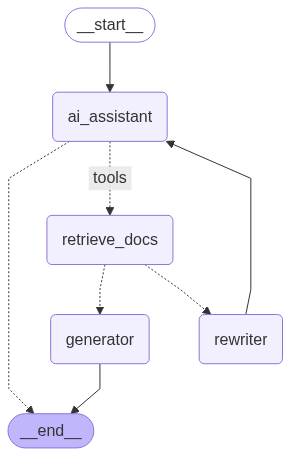

In [10]:
app=agentic_workflow.compile(checkpointer=memory)
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

##Példák

### Anova

In [61]:
question = "What is anova?"
response = agentic_answer(question)
print(response)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


---CALL AGENT---
Processing question: 'What is anova?'
Searching for: 'What is anova?'
Top retrieval scores: [0.91794753074646, 0.9003559947013855, 0.8993901014328003]
Retrieved content preview: Document 1:
Analysis of variance (ANOVA) is a collection of statistical models and their associated estimation procedures (such as the "variation" among and between groups) used to analyze the differe...
---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
Question keywords: ['anova?']
Keyword matches: 0 exact, 1 partial, ratio = 0.50


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Grader response: based on the provided documents, here's how they relate to the question "what is anova?":

**document 1:** this document provides a comprehensive
First attempt: being more lenient with relevance criteria
---DECISION: DOCS RELEVANT---
---GENERATE ANSWER---
Doksik:Document 1:
Analysis of variance (ANOVA) is a collection of statistical models and their associated estimation procedures (such as the "variation" among and between groups) used to analyze the differences among means. ANOVA was developed by the statistician Ronald Fisher. ANOVA is based on the law of total variance, where the observed variance in a particular variable is partitioned into components attributable to different sources of variation. In its simplest form, ANOVA provides a statistical test of whether two or more population means are equal, and therefore generalizes the t-test beyond two means. In other words, the ANOVA is used to test the difference between two or more means. While the analysis of va

###Einstein

In [63]:
question = "when did Einstein married?"
response = agentic_answer(question)
print(response)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


---CALL AGENT---
Processing question: 'when did Einstein married?'
Searching for: 'when did Einstein married?'
Top retrieval scores: [0.9235875010490417, 0.9142122268676758, 0.8791489601135254]
Retrieved content preview: Document 1:
Einstein and Marić married in January 1903. In May 1904, their son Hans Albert was born in Bern, Switzerland. Their son Eduard was born in Zürich in July 1910. In letters that Einstein wro...
---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
Question keywords: ['einstein', 'married?', 'einstein married?']
Keyword matches: 1 exact, 1 partial, ratio = 0.50


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Grader response: to determine whether the documents contain information useful for addressing the question "when did einstein marry?", let's analyze each document:

**document 1:** this document provides
Ambiguous grader response, using keyword matching as tiebreaker
First attempt: being more lenient with relevance criteria
---DECISION: DOCS RELEVANT---
---GENERATE ANSWER---
Doksik:Document 1:
Einstein and Marić married in January 1903. In May 1904, their son Hans Albert was born in Bern, Switzerland. Their son Eduard was born in Zürich in July 1910. In letters that Einstein wrote to Marie Winteler in the months before Eduard's arrival, he described his love for his wife as "misguided" and mourned the "missed life" that he imagined he would have enjoyed if he had married Winteler instead: "I think of you in heartfelt love every spare minute and am so unhappy as only a man can be." In 1912, Einstein entered into a relationship with Elsa Löwenthal, who was both his first cousin on his mo

In [64]:
docs[1500]

{'id': '674',
 'title': 'Anatomy',
 'text': 'The teaching of anatomy in Britain was transformed by Sir John Struthers, Regius Professor of Anatomy at the University of Aberdeen from 1863 to 1889. He was responsible for setting up the system of three years of "pre-clinical" academic teaching in the sciences underlying medicine, including especially anatomy. This system lasted until the reform of medical training in 1993 and 2003. As well as teaching, he collected many vertebrate skeletons for his museum of comparative anatomy, published over 70 research papers, and became famous for his public dissection of the Tay Whale. From 1822 the Royal College of Surgeons regulated the teaching of anatomy in medical schools. Medical museums provided examples in comparative anatomy, and were often used in teaching. Ignaz Semmelweis investigated puerperal fever and he discovered how it was caused. He noticed that the frequently fatal fever occurred more often in mothers examined by medical students 

###Anatomy

In [65]:
question = "Who changed the anatomy?"
response = agentic_answer(question)
print(response)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


---CALL AGENT---
Processing question: 'Who changed the anatomy?'
Searching for: 'Who changed the anatomy?'
Top retrieval scores: [0.8642034530639648, 0.8613422513008118, 0.8571059703826904]
Retrieved content preview: Document 1:
The teaching of anatomy in Britain was transformed by Sir John Struthers, Regius Professor of Anatomy at the University of Aberdeen from 1863 to 1889. He was responsible for setting up the...
---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
Question keywords: ['changed', 'anatomy?']
Keyword matches: 0 exact, 1 partial, ratio = 0.25


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Grader response: to determine whether the documents contain information useful for addressing the question "who changed the anatomy?", we need to analyze each document individually and see if it provides any relevant
Ambiguous grader response, using keyword matching as tiebreaker
First attempt: being more lenient with relevance criteria
---DECISION: DOCS RELEVANT---
---GENERATE ANSWER---
Doksik:Document 1:
The teaching of anatomy in Britain was transformed by Sir John Struthers, Regius Professor of Anatomy at the University of Aberdeen from 1863 to 1889. He was responsible for setting up the system of three years of "pre-clinical" academic teaching in the sciences underlying medicine, including especially anatomy. This system lasted until the reform of medical training in 1993 and 2003. As well as teaching, he collected many vertebrate skeletons for his museum of comparative anatomy, published over 70 research papers, and became famous for his public dissection of the Tay Whale. From 1

In [66]:
question = "How to resuscitation a newborn?"
response = agentic_answer(question)
print(response)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


---CALL AGENT---
Processing question: 'How to resuscitation a newborn?'
Searching for: 'How to resuscitation a newborn?'
Top retrieval scores: [0.7844970226287842, 0.7739355564117432, 0.7732609510421753]
Retrieved content preview: Document 1:
However, Hera had tricked Eileithyia, the goddess of childbirth, to stay on Olympus, due to which Leto was unable to give birth. The goddesses then convinced Iris to go bring Eileithyia by...
---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
Question keywords: ['resuscitation', 'newborn?']
Keyword matches: 0 exact, 0 partial, ratio = 0.00
---DECISION: DOCS NOT RELEVANT (keyword check)---
---TRANSFORM QUERY---


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Rewritten query (1): How to perform CPR on a newborn baby?
                
                Please rewrite this question to be more specific and use different keywords
                that might help retrieve relevant information. The rewrite should maintain
                the same intent but use different wording.
                
                Rewritten question:  How to perform CPR on a newborn baby?
---CALL AGENT---
Processing question: 'How to resuscitation a newborn?'
Searching for: 'How to resuscitation a newborn?'
Top retrieval scores: [0.7844970226287842, 0.7739355564117432, 0.7732609510421753]
Retrieved content preview: Document 1:
However, Hera had tricked Eileithyia, the goddess of childbirth, to stay on Olympus, due to which Leto was unable to give birth. The goddesses then convinced Iris to go bring Eileithyia by...
---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
Question keywords: ['resuscitation', 'newborn?']
Keyword matches: 0 exact, 0 partial, ratio = 0.00
---DECISI

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Rewritten query (2): How to perform CPR on a newborn baby?
                
                Please rewrite this question to be more specific and use different keywords
                that might help retrieve relevant information. The rewrite should maintain
                the same intent but use different wording.
                
                Rewritten question:  How to perform CPR on a newborn baby?
---CALL AGENT---
Processing question: 'How to resuscitation a newborn?'
Searching for: 'How to resuscitation a newborn?'
Top retrieval scores: [0.7844970226287842, 0.7739355564117432, 0.7732609510421753]
Retrieved content preview: Document 1:
However, Hera had tricked Eileithyia, the goddess of childbirth, to stay on Olympus, due to which Leto was unable to give birth. The goddesses then convinced Iris to go bring Eileithyia by...
---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---DECISION: FORCED GENERATOR AFTER 2 REWRITES---
---GENERATE ANSWER---
Doksik:Document 1:
However, Hera had

##bottleneck, tesztelés, továbbfejlesztés


**Bottleneck**
- A modell, 7B és még az is kvantálva, nem túl erős, de a döntéseket ő hozza, valószinűlég jobban működne egy erősebb modellel
- A kód jelenleg minden keresést valós időben végez, cache-elés nélkül
- Hardcodeolni kellett pár dolgot, az LLM minősége miatt (pl. a dokumentumok releváns tartalmához stopword-ök)
- memória nem működik, mert nem tudta kezelni az LLM (ismételgette az előző kérdést). Vagyis működik, csak minden hívásnál új memóriát kap ez miatt.

**Tesztelés**




Komponensek tesztelése:
- Retriever: Precision@k mérése (k=3), releváns dokumentumok aránya, különböző k értékek tesztelése
- Válaszgenerálás: Tényszerűség ellenőrzése, hallucinációk vizsgálata

Az egész rendszer tesztelése:
- Kérdés-válasz teszt adathalmaz készítése a meglévő dokumentumokból
- Ragas keretrendszer használata az elemzéséhez


**További fejlesztések**

- Párhuzamos feldolgozás (aszinkron feldolgozás különböző komponensek között)
- Dokumentum beágyazások cache-elése
- Gyakori kérdésekre adott válaszok tárolása
- Hatékonyabb chunking stratégiák (pl. szemantikai)
- Hibrid keresés (szemantikai és kulcsszó)